In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
data = pd.read_csv('features.csv', sep=';')
timelines = pd.read_csv('timelines.csv', sep=';')

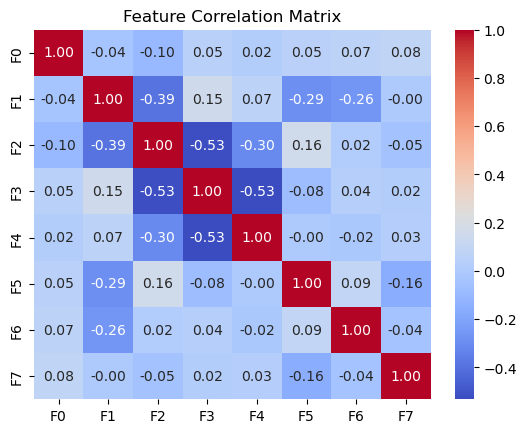

In [98]:
# Check correlation between features in data

# Save a copy of the ID column
id_column = data["ID"].copy()

# Remove ID column
numerical_data = data.drop(columns=["ID"])

correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

None of the features have a high enough correlation to be removed. Moreover, because we don't know the origin of the features we might miss non-linear correlations if we end up removing some features.

Let us observe if there are any outliers and the distribution of the features. We will decide whether to normalize or standardize the features based on their distributions.

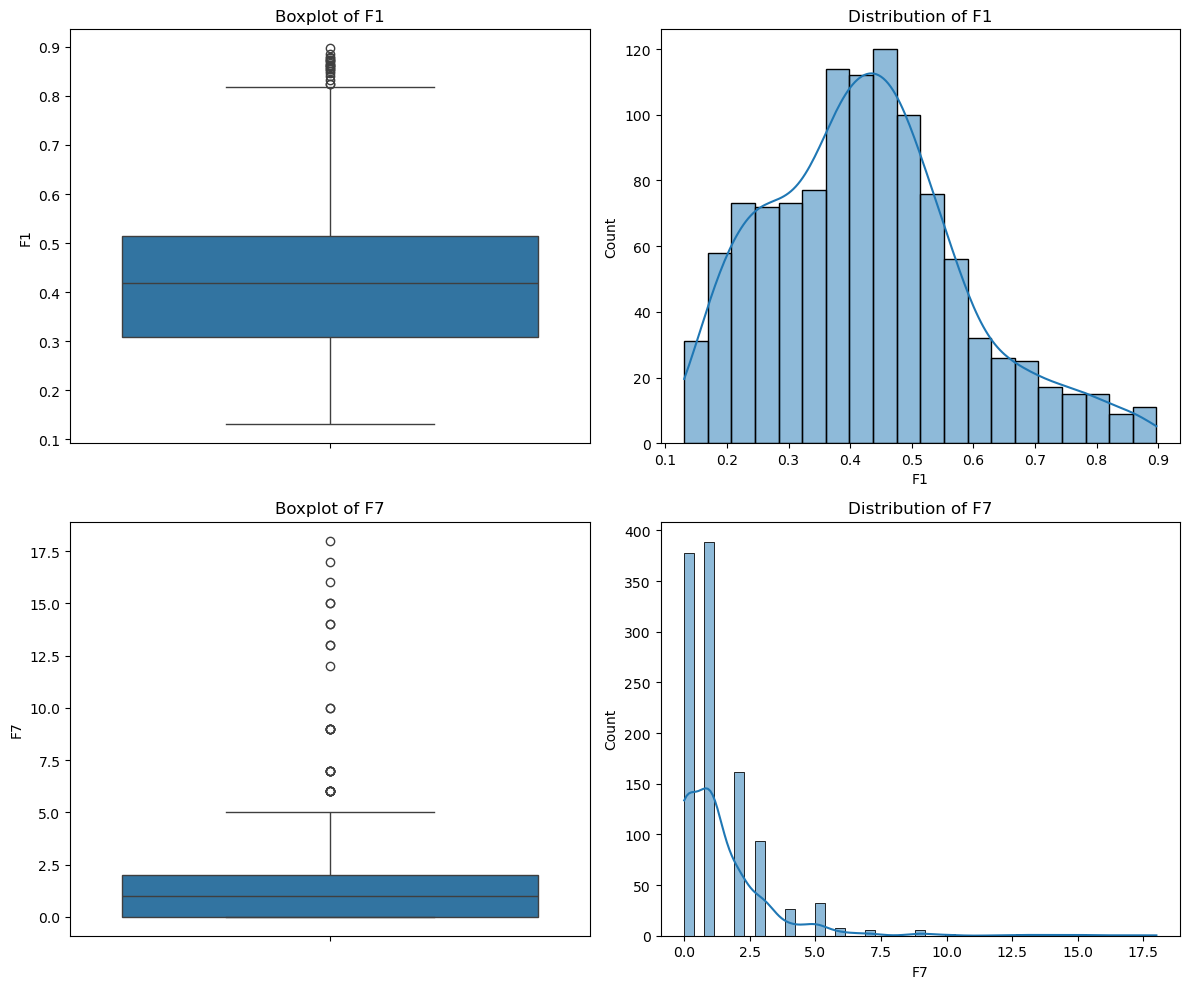

In [99]:
# Outlier detection and distribution analysis with subplots in a single figure

# Only consider non-binary columns for this analysis
binary_columns = [col for col in numerical_data.columns if set(numerical_data[col].unique()) <= {0, 1}]
non_binary_data = numerical_data.drop(columns=binary_columns)
num_columns = len(non_binary_data.columns)
fig, axes = plt.subplots(num_columns, 2, figsize=(12, 5 * num_columns))

for i, column in enumerate(non_binary_data.columns):
    # Boxplot
    sns.boxplot(y=non_binary_data[column], ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot of {column}")
    
    # Histogram
    sns.histplot(non_binary_data[column], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Distribution of {column}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Let us normalize the feature `F7`.


In [100]:
# Normalize feature F7
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_data["F7"] = scaler.fit_transform(numerical_data[["F7"]])

Now, notice that for the `timelines` dataframe, we have some rows where the first time point is 0. This means that no event occured during the observation period or the patient left the study, which might not be meaningful for our analysis. We will remove these rows to ensure we focus patients with actual events. 

In [101]:
# Remove rows in timelines where time_1 is 0
timelines = timelines[timelines["time_1"] != 0].reset_index(drop=True)

# Only keep matching IDs in both dataframes
numerical_data["ID"] = id_column
numerical_data = numerical_data[numerical_data["ID"].isin(timelines["ID"])].reset_index(drop=True)


Let us cluster the data to see if we can find some patterns. We will use a simple Kmeans clustering algorithm without considering the `ID` column.

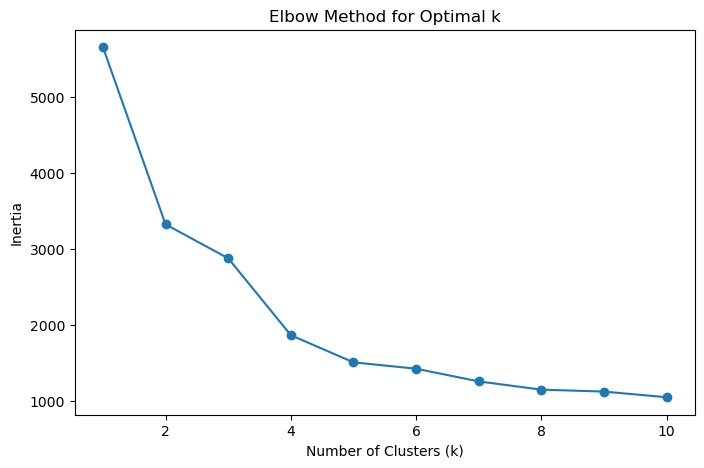

In [102]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

numerical_data = data.drop(columns=["ID"])

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(numerical_data)

# Elbow method to find optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(numerical_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


Based on the elbow method, it seems like the optimal number of clusters is around 3. Let's proceed with this number of clusters for our KMeans algorithm.

In [103]:
optimal_k = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_k)

cluster_data = numerical_data.copy()
cluster_data['ID'] = id_column
clusters = kmeans.fit_predict(numerical_data)
cluster_data['Cluster'] = clusters

In [104]:
print("Cluster sizes:")
print(cluster_data["Cluster"].value_counts())
cluster_data.reset_index(drop=True, inplace=True)


Cluster sizes:
Cluster
0    496
2    433
1    183
Name: count, dtype: int64


Let us visualize the pca loadings to understand which features contribute the most to each principal component.

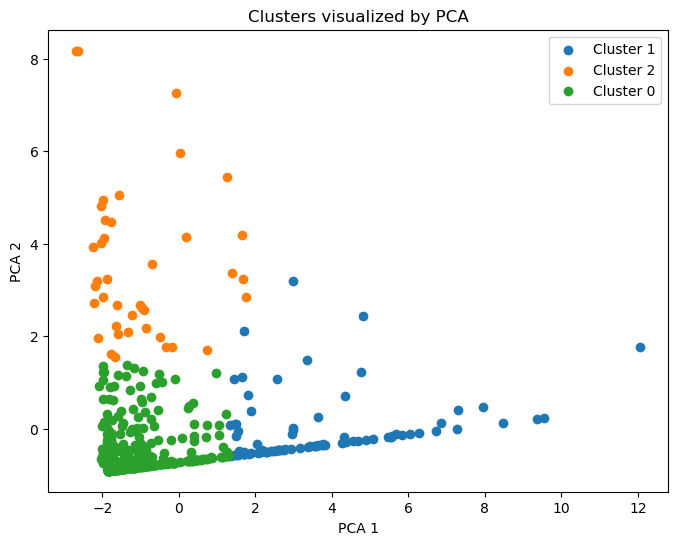

Cumulative explained variance by PCA components: [0.59159969 0.81681847]


In [46]:
from sklearn.decomposition import PCA
import numpy as np

# Exclude categorical columns for PCA
pca = PCA(n_components=2)
features = numerical_data.values
components = pca.fit_transform(features)

plt.figure(figsize=(8,6))
for cluster in cluster_data["Cluster"].unique():
    idx = cluster_data["Cluster"] == cluster
    plt.scatter(components[idx, 0], components[idx, 1], label=f"Cluster {cluster}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters visualized by PCA")
plt.legend()
plt.show()

print("Cumulative explained variance by PCA components:", np.cumsum(pca.explained_variance_ratio_))


The cumulative explained variance for 2 principal components is around 81.6%, which is good enough for our analysis. Nevertheless, let's visualize the data in 3D with 3 principal components to see if we can capture more variance.

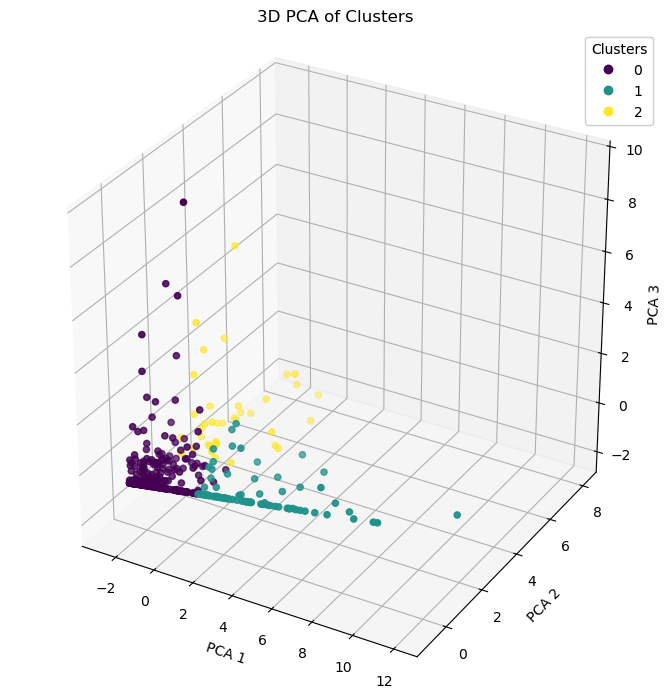

Cumulative explained variance by PCA components: [0.59159969 0.81681847 0.92295575]


In [62]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Exclude categorical columns for PCA
pca = PCA(n_components=3)
features = numerical_data.values
components = pca.fit_transform(features)

# 3D Scatter plot of clusters based on 3 PCA components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(components[:, 0], components[:, 1], components[:, 2], c=clusters, cmap='viridis')
ax.set_title("3D PCA of Clusters")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

fig.tight_layout()
ax.set_box_aspect([1,1,1])  

plt.show()


print("Cumulative explained variance by PCA components:", np.cumsum(pca.explained_variance_ratio_))

Let us visualize the pca loadings to understand which features contribute the most to each principal component.

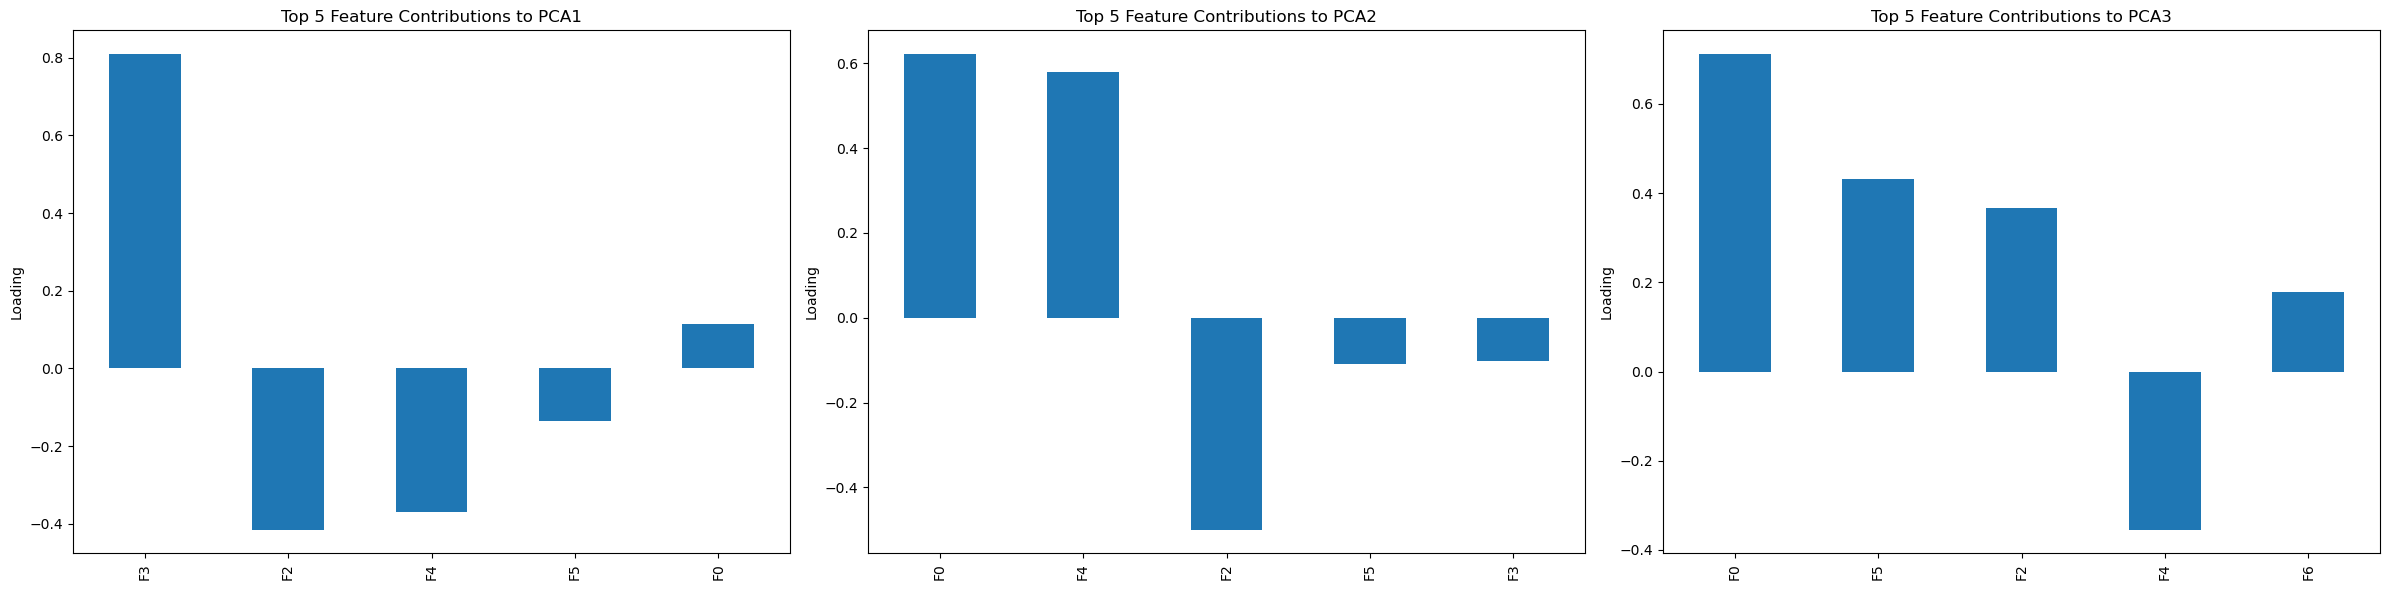

In [11]:
# Create subplots for PCA loadings
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

pca_loadings = pd.DataFrame(pca.components_.T, index=numerical_data.columns, columns=["PCA1", "PCA2", "PCA3"])

# Top 5 features for PCA1 by absolute value, but plot signed values
top5_pca1 = pca_loadings["PCA1"].abs().sort_values(ascending=False).head(5).index
pca_loadings.loc[top5_pca1, "PCA1"].plot(kind="bar", ax=axes[0])
axes[0].set_title("Top 5 Feature Contributions to PCA1")
axes[0].set_ylabel("Loading")

# Top 5 features for PCA2 by absolute value, but plot signed values
top5_pca2 = pca_loadings["PCA2"].abs().sort_values(ascending=False).head(5).index
pca_loadings.loc[top5_pca2, "PCA2"].plot(kind="bar", ax=axes[1])
axes[1].set_title("Top 5 Feature Contributions to PCA2")
axes[1].set_ylabel("Loading")

# Top 5 features for PCA3 by absolute value, but plot signed values
top5_pca3 = pca_loadings["PCA3"].abs().sort_values(ascending=False).head(5).index
pca_loadings.loc[top5_pca3, "PCA3"].plot(kind="bar", ax=axes[2])
axes[2].set_title("Top 5 Feature Contributions to PCA3")
axes[2].set_ylabel("Loading")

plt.tight_layout()
plt.show()

It seems like the feature `F3` contributes the most to the first principal component, while `F0` contributes the most to the second and third  principal components. Note that these are all binary features. Normalizing the feature `F7` has significantly shifted its contribution to the principal components.

After clustering, let us now compute the absolute value of the timestamps for the `timelines` dataset. That is, the time in months that have passed since the study started for each event and for each patient.


In [12]:
# Compute absolute timestamps in months for each event in timelines
absolute_timelines = timelines.copy()

# Replace relative time columns with absolute times.
time_columns = [col for col in absolute_timelines.columns if col.startswith('time')]
absolute_timelines[time_columns] = absolute_timelines[time_columns].cumsum(axis=1)
absolute_timelines[time_columns] = absolute_timelines[time_columns].where(absolute_timelines[time_columns] != 0, 0)

# For each patient, if the next event has same timestamp as the previous event, set it to 0 and all the following timestamps to 0 as well.
for patient_id in absolute_timelines['ID'].unique():
    patient_mask = absolute_timelines['ID'] == patient_id
    patient_times = absolute_timelines.loc[patient_mask, time_columns]
    for i in range(1, len(time_columns)):
        same_time_mask = patient_times[time_columns[i]] == patient_times[time_columns[i - 1]]
        if same_time_mask.any():
            absolute_timelines.loc[patient_mask & same_time_mask, time_columns[i:]] = 0
            break  

Finally, we add a `trace_end` column to indicate the end of each patient's timeline. This will help in understanding the duration of each patient's participation in the study.

In [13]:
import numpy as np

def get_trace_end(row):
    non_zero_indices = np.nonzero(row.values)[0]
    if len(non_zero_indices) == 0:
        return np.nan  # or 0 or whatever you want to indicate no events
    last_non_zero_value = row.iloc[non_zero_indices[-1]]
    return last_non_zero_value + 1

absolute_timelines["trace_end"] = absolute_timelines[time_columns].apply(get_trace_end, axis=1)

Notice that some patients don't have any observed events in the time of the study, thus a `trace_end` cannot be computed for them.  We have decided to remove them from the analysis. We have no way of knowing if they dropped out of the study or if they just didn't have any events during the study period.

In [200]:
# Remove rows of patients with `time_1` equal to 0
absolute_timelines = absolute_timelines[absolute_timelines["time_1"] != 0].reset_index(drop=True)

In [201]:
print(len(absolute_timelines), "patients with at least one event recorded.")

415 patients with at least one event recorded.
